In [1]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib import rcParams
import camb

from cosmopy.cosmology import flatLCDM # https://github.com/Yucheng-Zhang/cosmopy
from cosmocl import theocl

In [2]:
rcParams.update({'font.size': 22})

In [3]:
# default Planck 2018 cosmology
cosmo = flatLCDM()
# initialize
cc = theocl.cc(cosmo)
ccl = theocl.ccl_limber(cc)
ells = np.arange(2, 1001, 1)

---

In [4]:
# calculate C_ell^kk for the ells
clkk = ccl.c_clxy_limber('kappa', 'kappa', ells) # ~ 1 min to run

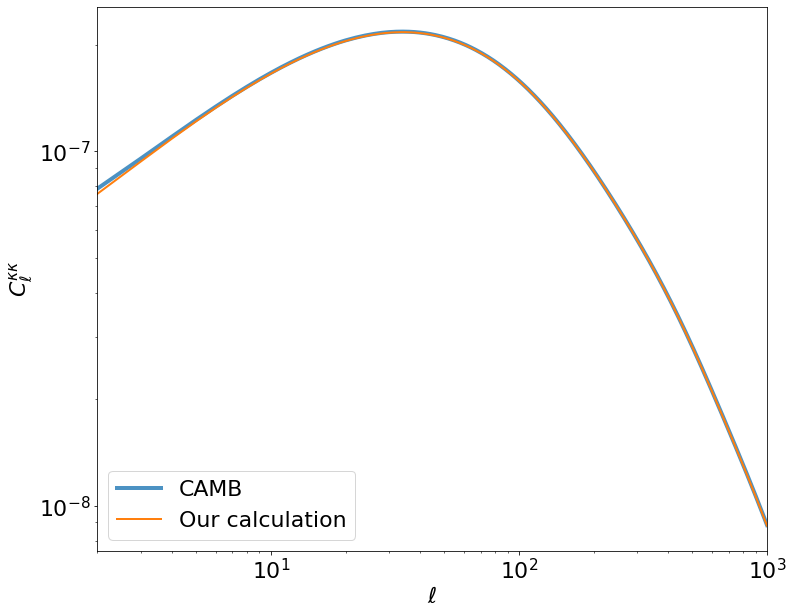

In [5]:
# check our C_ell^kk calculation with CAMB

# get CAMB C_ell^kk
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.66, ombh2=0.02242, omch2=0.11933, TCMB=2.7255)
pars.InitPower.set_params(As=2.105e-9, ns=0.9665)
pars.set_for_lmax(1000, lens_potential_accuracy=2)
pars.NonLinear = camb.model.NonLinear_none
results = camb.get_results(pars)
clkk_camb = results.get_lens_potential_cls(lmax=1000)[2:, 0] * np.pi / 2

# plot
fig, (ax) = plt.subplots(1, 1, figsize=(12, 10))

ax.plot(ells, clkk_camb, lw=4, alpha=0.8, label='CAMB')
ax.plot(ells, clkk, lw=2, label='Our calculation')

ax.set_xscale('log'); ax.set_xlim(2, 1000); ax.set_xlabel(r'$\ell$')
ax.set_yscale('log'); ax.set_ylabel(r'$C_\ell^{\kappa\kappa}$')

ax.legend()
plt.show()

---

In [6]:
# setup a galaxy survey

# a toy model of the redshift distribution
def n_unnorm(z, z_s=0.3, a=2.0, b=1.0):
    '''number density redshift distribution, unnormalized'''
    return np.power(z/z_s, a) * np.exp(-np.power(z/z_s, b))

zg1, zg2 = 0.5, 1.0
n_norm = integrate.quad(n_unnorm, zg1, zg2, epsabs=0.0, epsrel=1e-8)[0]

def fg(z):
    '''normalized (for the bin) redshift distribution'''
    return n_unnorm(z) / n_norm

def bg(z):
    '''linear bias'''
    return 1. + z

# initialize with galaxy survey info
cc = theocl.cc(cosmo, fg=fg, bg=bg, zg1=zg1, zg2=zg2)
ccl = theocl.ccl_limber(cc)

In [7]:
# calculate C_ell^kg and C_ell^gg for the ells
clkg = ccl.c_clxy_limber('kappa', 'g', ells)
clgg = ccl.c_clxy_limber('g', 'g', ells)

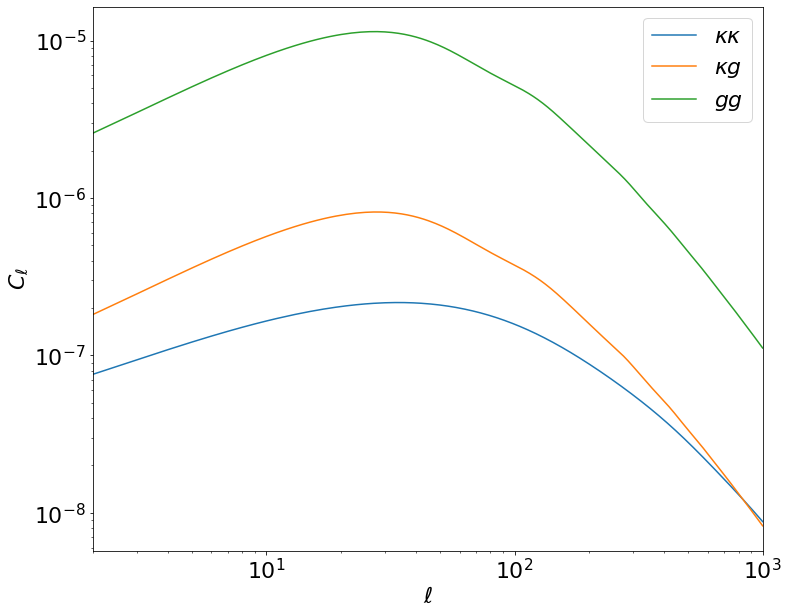

In [8]:
# plot
fig, (ax) = plt.subplots(1, 1, figsize=(12, 10))

ax.plot(ells, clkk, label=r'$\kappa \kappa$')
ax.plot(ells, clkg, label=r'$\kappa g$')
ax.plot(ells, clgg, label=r'$g g$')

ax.set_xscale('log'); ax.set_xlim(2, 1000); ax.set_xlabel(r'$\ell$')
ax.set_yscale('log'); ax.set_ylabel(r'$C_\ell$')

ax.legend()
plt.show()

---

In [14]:
# 'kappa' or 'g' variables taken by the functions above denote the transfer (window) functions of the fields
# other options are (not verified, might be wrong :) 
# 'g_NL' : non-Gaussianity of the local-type, correction to galaxy bias
# 'g_R' : Redshift-Space Dsitortion
# 'g_M' : magnification bias (not coded yet)

# for example, the correction to clkg due to RSD
clkg_R = ccl.c_clxy_limber('kappa', 'g_R', ells)
# f_NL
clkg_NL = ccl.c_clxy_limber('kappa', 'g_NL', ells)

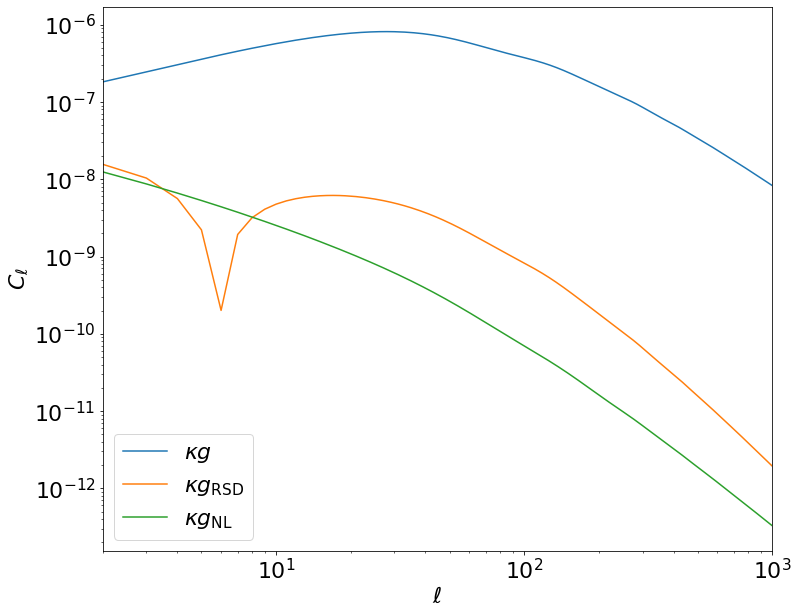

In [15]:
# plot
fig, (ax) = plt.subplots(1, 1, figsize=(12, 10))

ax.plot(ells, clkg, label=r'$\kappa g$')
ax.plot(ells, clkg_NL, label=r'$\kappa g_{\rm NL}$')

ax.plot(ells, np.abs(clkg_R), label=r'$\kappa g_{\rm RSD}$')
# This looks kind of wired for low ells, may be due to Limber approximation.

ax.set_xscale('log'); ax.set_xlim(2, 1000); ax.set_xlabel(r'$\ell$')
ax.set_yscale('log'); ax.set_ylabel(r'$C_\ell$')

ax.legend()
plt.show()

---